# Twitter Stance Detection  
W266 - NLP  
Alex Dessouky & Tim Spittle

## Setup  

### Packages

In [1]:
# System and Storage
import time
import os
import sys
from datetime import datetime
now = datetime.now() # current date and time

# Data structures
import pandas as pd
import numpy as np

# Strings
import string
import re

# Pre-Processing
from sklearn.preprocessing import OneHotEncoder
from itertools import compress
from sklearn.utils.class_weight import compute_class_weight

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Outputs
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Paths & Local Packages

In [2]:
## PATH STUFF FIRST SO EASY TO SWITCH BETWEEN US ##

# Set working directory
# os.chdir("/Users/alexdessouky/Desktop/MIDS/w266")
# os.chdir("/Users/manat/OneDrive/Documents/Tim/MIDS/266_NLP/Final Project")

# Store the paths to bert & data
# bert_path =   '/Users/alexdessouky/Desktop/MIDS/w266/bert' 
# data_path = '/Users/alexdessouky/Desktop/MIDS/w266/w266_final_project/StanceDataset'  
# TIM LOCAL
# bert_path = r'C:\Users\manat\OneDrive\Documents\Tim\MIDS\266_NLP\w266\bert\\' # change as needed
# data_path = r'C:\Users\manat\OneDrive\Documents\Tim\MIDS\266_NLP\Final Project\w266_final_project\StanceDataset'  
# TIM CLOUD
bert_path = r'/home/timspittle/w266_final_project/bert/' 
data_path = r'/home/timspittle/w266_final_project/StanceDataset/'  

# Make sure that the paths are accessible within the notebook
sys.path.insert(0, bert_path)
sys.path.insert(0, data_path)

In [3]:
# Packages imported from bert local path
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

### Import Raw Data

In [4]:
# Load data
# Training data
# twitter_train = pd.read_excel('./w266_final_project/StanceDataset/train.xlsx')
twitter_train_raw = pd.read_excel('./StanceDataset/train.xlsx')

# Test data
# twitter_test = pd.read_excel('./w266_final_project/StanceDataset/test.xlsx')
twitter_test_raw = pd.read_excel('./StanceDataset/test.xlsx')

print("Training (shape): " + str(twitter_train_raw.shape))
print("Test (shape): " + str(twitter_test_raw.shape))
twitter_train_raw.head()

Training (shape): (2914, 5)
Test (shape): (1956, 5)


,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


## Pre-Process Data  

### Labels $y$

In [5]:
# Text Labels (needed for plotting)
labels_text_train = np.array(twitter_train_raw['Stance'])
labels_text_test = np.array(twitter_test_raw['Stance'])

# One-hot Encoder
enc_labels = OneHotEncoder(handle_unknown = 'ignore')
enc_labels.fit(labels_text_train.reshape(-1, 1))
label_categories = enc_labels.categories_[0]

# Encoded Labels (for NN)
labels_encoded_train = enc_labels.transform(labels_text_train.reshape(-1, 1)).toarray()
labels_encoded_test = enc_labels.transform(labels_text_test.reshape(-1, 1)).toarray()

print(label_categories)
print(labels_encoded_train[:5])

['AGAINST' 'FAVOR' 'NONE']
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [6]:
stance_count_long_train = twitter_train_raw[['Target','Stance', 'Tweet']].groupby(['Target','Stance']).count()
stance_count_long_train# stance_count_long_train.pivot(index='Target', columns='Stance', values='Tweet')

Tweet
Target                           Stance        
Atheism                          AGAINST    304
                                 FAVOR       92
                                 NONE       117
Climate Change is a Real Concern AGAINST     15
                                 FAVOR      212
                                 NONE       168
Feminist Movement                AGAINST    328
                                 FAVOR      210
                                 NONE       126
Hillary Clinton                  AGAINST    393
                                 FAVOR      118
                                 NONE       178
Legalization of Abortion         AGAINST    355
                                 FAVOR      121
                                 NONE       177

In [7]:
stance_count_long_test = twitter_test_raw[['Target','Stance', 'Tweet']].groupby(['Target','Stance']).count()
stance_count_long_test

Tweet
Target                           Stance        
Atheism                          AGAINST    160
                                 FAVOR       32
                                 NONE        28
Climate Change is a Real Concern AGAINST     11
                                 FAVOR      123
                                 NONE        35
Donald Trump                     AGAINST    299
                                 FAVOR      148
                                 NONE       260
Feminist Movement                AGAINST    183
                                 FAVOR       58
                                 NONE        44
Hillary Clinton                  AGAINST    172
                                 FAVOR       45
                                 NONE        78
Legalization of Abortion         AGAINST    189
                                 FAVOR       46
                                 NONE        45

### Tokens $x$

In [8]:
def preprocess_tweets(x):
    
    # Remove punctuation EXCEPT for hashtags (#) and handles (@)
    exclude_punc = [punc for punc in string.punctuation if punc not in ['#', '@']]
    x_nopunc = ''.join(ch for ch in x if ch not in exclude_punc)

    # lower case
    x_lower = x_nopunc.lower()
    
    # Replace digits with DIGIT
    x_digits = re.sub("\d+", "DIGIT", x_lower)
    
    return x_digits

# Clean tweests
twitter_train_raw['tweet_prep'] = np.array(twitter_train_raw['Tweet'].apply(lambda x: preprocess_tweets(x)))
twitter_test_raw['tweet_prep'] = np.array(twitter_test_raw['Tweet'].apply(lambda x: preprocess_tweets(x)))

# Example tweet
print("Raw: " + str(twitter_train_raw['Tweet'][0]))
print("Clean: " + str(preprocess_tweets(twitter_train_raw['Tweet'][0])))

Raw: @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot
Clean: @tedcruz and #handovertheserver she wiped clean  DIGITk deleted emails explains dereliction of dutylies re #benghazietc #tcot


### Bert tokenizer

In [9]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [10]:
# Create tokens surrounded by the [CLS] and [SEP] tokens
tokens_train = twitter_train_raw['tweet_prep'].apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])
tokens_test = twitter_test_raw['tweet_prep'].apply(lambda x: ['[CLS]'] + tokenizer.tokenize(x) + ['[SEP]'])

In [11]:
# Define maximal length of input 'sentences' (post tokenization).
sen_length_list = []
for sent in tokens_train.append(tokens_test):
    sen_length_list.append(len(sent))
max_length = np.max(sen_length_list)

In [12]:
def bert_lists(tokens_in, max_length_in):

    # Mask ids (mask out the paddings)
    mask_ids = tokens_in.apply(lambda x: len(x)*[1])
    
    mask_ids = mask_ids.apply(lambda x: np.array(x + (max_length_in - len(x)) * [0])
                              if len(x) < max_length_in else np.array(x)).tolist()
    
    # Add padding to tokens
    tokens_pad = tokens_in.apply(lambda x: x + (max_length_in - len(x)) * ['[PAD]'] if len(x) < max_length_in else x)
    
    # Sequence vectors
    sequenceids = tokens_pad.apply(lambda x: np.array(max_length_in*[0])).tolist()
    
    # Convert tokens to sentence ids
    sentenceids = tokens_pad.apply(lambda x: tokenizer.convert_tokens_to_ids(x)).tolist()
    
    # Bert features
    bert = [np.array(sentenceids), np.array(mask_ids), np.array(sequenceids)]
    return(bert)

In [13]:
bert_train = bert_lists(tokens_in = tokens_train, max_length_in = max_length)
bert_test = bert_lists(tokens_in = tokens_test, max_length_in = max_length)

In [14]:
print(twitter_train_raw['tweet_prep'][0])
print(tokens_train[0])
# NOTES: why such small tokens? e.g. benghazi and ted cruz have to be important tokens by themselves, right?
    # If mask token is "#" we're losing out on hashtags
print(bert_train[0])
# NOTES: converting tokens to IDs makes sense, why call them sentence IDs?
print(bert_train[1])
# NOTES: is this just a 0 for PADs?
print(bert_train[2])
# NOTES: what the hell is this? all 0's?

@tedcruz and #handovertheserver she wiped clean  DIGITk deleted emails explains dereliction of dutylies re #benghazietc #tcot
['[CLS]', '@', 'te', '##d', '##c', '##ru', '##z', 'and', '#', 'hand', '##over', '##the', '##serve', '##r', 'she', 'wiped', 'clean', 'D', '##IG', '##IT', '##k', 'deleted', 'emails', 'explains', 'der', '##eli', '##ction', 'of', 'duty', '##lies', 're', '#', 'ben', '##gh', '##azi', '##et', '##c', '#', 't', '##cot', '[SEP]']
[[  101   137 21359 ...     0     0     0]
 [  101  4665  3113 ...     0     0     0]
 [  101   137  1103 ...     0     0     0]
 ...
 [  101  1293  9164 ...     0     0     0]
 [  101  4463  2266 ...     0     0     0]
 [  101   108  9814 ...     0     0     0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [15]:
# CHECK SIZES
print(str(bert_train[0].shape) +", "+  str(bert_train[1].shape) +", "+ str(bert_train[2].shape))
print(labels_encoded_train.shape)

print(str(bert_test[0].shape) +", "+  str(bert_test[1].shape) +", "+ str(bert_test[2].shape))
print(labels_encoded_test.shape)

(2914, 95), (2914, 95), (2914, 95)
(2914, 3)
(1956, 95), (1956, 95), (1956, 95)
(1956, 3)


## Subset by Target

In [16]:
def topic_subset(targets_in, labels_text_in, labels_encoded_in, bert_in, topic_in):
        
    # Convert topic lower case
    topic_in = topic_in.lower()
    
    # Find boolean series of all rows pertaining to the relevant topics
    matches_target_topic = targets_in.apply(lambda x: x.lower() == topic_in)
    
    # LABELS
    labels_text_sub = labels_text_in[matches_target_topic]
    labels_encoded_sub = labels_encoded_in[matches_target_topic,:]
    compute_class = compute_class_weight('balanced', np.unique(labels_text_sub), labels_text_sub)
    weights = {0: compute_class[0], 1:compute_class[1], 2:compute_class[2]}
    
    # BERT
    bert_sub = []
    for input_list in bert_in:
        bert_sub.append(input_list[matches_target_topic])
        
    # Output Dictionary
    subset_dict = {}
    subset_dict['target'] = topic_in
    subset_dict['labels_text'] = labels_text_sub
    subset_dict['labels_encoded'] = labels_encoded_sub
    subset_dict['class_weights'] = weights
    subset_dict['bert'] = bert_sub
    
    return subset_dict

In [58]:
target_list = list(set(twitter_train_raw['Target']))
target_list.sort()
target_atheism = target_list[0]
target_climate_change = target_list[1]
target_feminism = target_list[2]
target_hillary = target_list[3]
target_abortion = target_list[4]
target_list

['Atheism',
 'Climate Change is a Real Concern',
 'Feminist Movement',
 'Hillary Clinton',
 'Legalization of Abortion']

In [59]:
#### Abortion
abortion_train_subset = topic_subset(targets_in = twitter_train_raw['Target'], 
                                    labels_text_in = labels_text_train, 
                                    labels_encoded_in = labels_encoded_train, 
                                    bert_in = bert_train, 
                                    topic_in = target_abortion)

abortion_test_subset = topic_subset(targets_in = twitter_test_raw['Target'], 
                                    labels_text_in = labels_text_test, 
                                    labels_encoded_in = labels_encoded_test, 
                                    bert_in = bert_test, 
                                    topic_in = target_abortion)

In [60]:
#### Atheism
atheism_train_subset = topic_subset(targets_in = twitter_train_raw['Target'], 
                                    labels_text_in = labels_text_train, 
                                    labels_encoded_in = labels_encoded_train, 
                                    bert_in = bert_train, 
                                    topic_in = target_atheism)

atheism_test_subset = topic_subset(targets_in = twitter_test_raw['Target'], 
                                    labels_text_in = labels_text_test, 
                                    labels_encoded_in = labels_encoded_test, 
                                    bert_in = bert_test, 
                                    topic_in = target_atheism)

In [61]:
#### Climate Change
climate_change_train_subset = topic_subset(targets_in = twitter_train_raw['Target'], 
                                    labels_text_in = labels_text_train, 
                                    labels_encoded_in = labels_encoded_train, 
                                    bert_in = bert_train, 
                                    topic_in = target_climate_change)

climate_change_test_subset = topic_subset(targets_in = twitter_test_raw['Target'], 
                                    labels_text_in = labels_text_test, 
                                    labels_encoded_in = labels_encoded_test, 
                                    bert_in = bert_test, 
                                    topic_in = target_climate_change)

In [62]:
#### Feminism
feminism_train_subset = topic_subset(targets_in = twitter_train_raw['Target'], 
                                    labels_text_in = labels_text_train, 
                                    labels_encoded_in = labels_encoded_train, 
                                    bert_in = bert_train, 
                                    topic_in = target_feminism)

feminism_test_subset = topic_subset(targets_in = twitter_test_raw['Target'], 
                                    labels_text_in = labels_text_test, 
                                    labels_encoded_in = labels_encoded_test, 
                                    bert_in = bert_test, 
                                    topic_in = target_feminism)

In [63]:
#### Hillary
hillary_train_subset = topic_subset(targets_in = twitter_train_raw['Target'], 
                                    labels_text_in = labels_text_train, 
                                    labels_encoded_in = labels_encoded_train, 
                                    bert_in = bert_train, 
                                    topic_in = target_hillary)

hillary_test_subset = topic_subset(targets_in = twitter_test_raw['Target'], 
                                    labels_text_in = labels_text_test, 
                                    labels_encoded_in = labels_encoded_test, 
                                    bert_in = bert_test, 
                                    topic_in = target_hillary)

In [64]:
len(twitter_train_raw['Target']) == len(abortion_train_subset['labels_text']) + len(atheism_train_subset['labels_text']) + len(climate_change_train_subset['labels_text']) + len(feminism_train_subset['labels_text']) + len(hillary_train_subset['labels_text'])

True

## Custom layer to create Bert

In [24]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, n_fine_tune_layers=10, **kwargs):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            bert_url,
            trainable=self.trainable,
            name="{}_module".format(self.name)
        )
        trainable_vars = self.bert.variables
        
        # Remove unused layers
        trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name and not "/pooler/" in var.name]
        
        # Select how many layers to fine tune
        trainable_vars = trainable_vars[-self.n_fine_tune_layers :]
        
        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)
        
        # Add non-trainable weights
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
        
        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            "sequence_output"
        ]
        
        mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
        
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

## Define Model

In [25]:
# NTOE: paramterized a lot of this setup

def bert_lstm_model(max_length_in, optimizer, 
                    bert_fine_tune_layers = 15, learning_rate_in = 0.01, dropout_rate_in = 0.8):
    
    in_id = tf.keras.layers.Input(shape=(max_length_in,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length_in,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length_in,), name="segment_ids")
    
    bert_inputs = [in_id, in_mask, in_segment]
    bert_sequence = BertLayer(n_fine_tune_layers=bert_fine_tune_layers)(bert_inputs)
    dropout1= tf.keras.layers.Dropout(rate=dropout_rate_in)(bert_sequence)
    
    # Bi-Directional?
    lstm1 = tf.keras.layers.LSTM(128, name='lstm1')(dropout1)
    
    dense1 = tf.keras.layers.Dense(64, 
                                   activation='relu', 
                                   kernel_initializer = tf.keras.initializers.he_normal(), 
                                   name='dense1')(lstm1)
    dropout2 = tf.keras.layers.Dropout(rate=dropout_rate_in)(dense1)
    
    pred = tf.keras.layers.Dense(3, activation='softmax', name='classification')(dropout2)
    
    tf.keras.optimizers.Adam(learning_rate=learning_rate_in)
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = ['categorical_accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [26]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.ylim([-0.5, 2.5]) # Fixed values for now
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [117]:
def standard_metrics(true_labels, test_probs, label_titles):
    # Find predicted labels
    test_prob_max = np.argmax(test_probs, axis = 1)

    test_predicts = []
    for i in range(len(test_prob_max)):
        test_predicts.append(label_titles[test_prob_max[i]])
    
    # F1 score
    f1 = f1_score(true_labels, test_predicts, labels = label_titles[:2], average = 'macro')
    print("F1 macro score (AGINST and FAVOR only):", f1)
    
    # Classification Report
    print(classification_report(y_true = true_labels, 
                                y_pred = test_predicts,
                                target_names = label_titles))
    
    # Confusion Matrix plot
    confuse = confusion_matrix(y_true = true_labels, y_pred = test_predicts)
    plt.figure(figsize = (20, 5))
    confusion_plot(confuse, label_titles)
    plt.show()

## Hyperparameter Tuning  
### Hillary

#### Baseline

In [65]:
unique_hillary, unique_count_hillary = np.unique(hillary_train_subset['labels_text'], return_counts=True)
max_class_hillary = unique_hillary[np.argmax(unique_count_hillary)]
class_template = np.zeros(3)
class_template[np.argmax(unique_count_hillary)] = 1
max_class_pred_hillary = np.tile(class_template, reps = (len(hillary_test_subset['labels_text']), 1))

F1 macro score: 0.3683083511777302
              precision    recall  f1-score   support

     AGAINST       0.58      1.00      0.74       172
       FAVOR       0.00      0.00      0.00        45
        NONE       0.00      0.00      0.00        78

    accuracy                           0.58       295
   macro avg       0.19      0.33      0.25       295
weighted avg       0.34      0.58      0.43       295



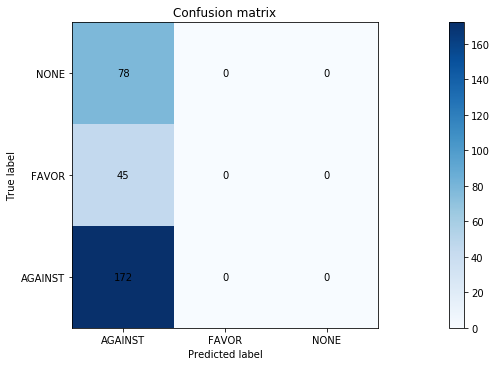

In [118]:
standard_metrics(true_labels = hillary_test_subset['labels_text'], 
                 test_probs = max_class_pred_hillary,
                 label_titles = label_categories)

#### Iterate Model

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 95)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

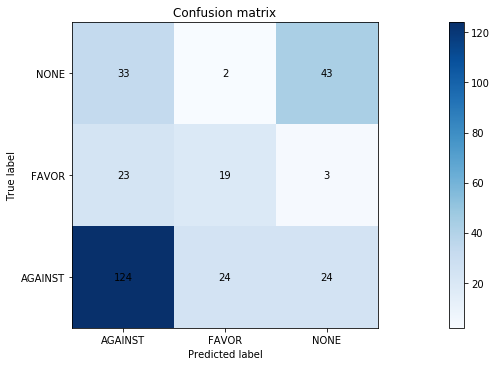

In [120]:
sess = tf.Session()

model_hillary = bert_lstm_model(max_length_in = max_length, 
                                bert_fine_tune_layers = 12, 
                                optimizer = 'adam',
                                learning_rate_in = 0.05,
                                dropout_rate_in = 0.8)

initialize_vars(sess)

model_hillary.fit(
    x = hillary_train_subset['bert'], 
    y = hillary_train_subset['labels_encoded'],
#     validation_split = 0.1,
    shuffle = True,
    epochs = 20,
    verbose = 2,
    batch_size = 100,
    class_weight = hillary_train_subset['class_weights'])

pred_test_hillary = model_hillary.predict(x = hillary_test_subset['bert'])

standard_metrics(true_labels = hillary_test_subset['labels_text'], 
                 test_probs = pred_test_hillary,
                 label_titles = label_categories)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 95)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
bert_layer_2 (BertLayer)        (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

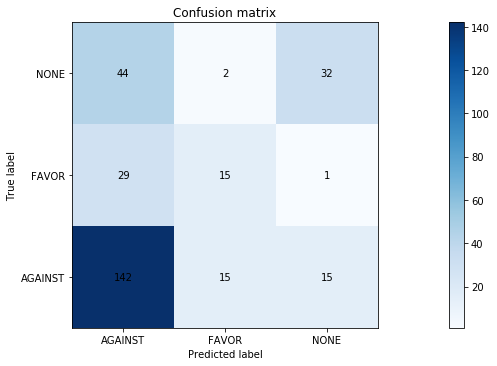

In [121]:
sess = tf.Session()

model_hillary = bert_lstm_model(max_length_in = max_length, 
                                bert_fine_tune_layers = 12, 
                                optimizer = 'adam',
                                learning_rate_in = 0.025,
                                dropout_rate_in = 0.8)

initialize_vars(sess)

model_hillary.fit(
    x = hillary_train_subset['bert'], 
    y = hillary_train_subset['labels_encoded'],
#     validation_split = 0.1,
    shuffle = True,
    epochs = 20,
    verbose = 2,
    batch_size = 32,
    class_weight = hillary_train_subset['class_weights'])

pred_test_hillary = model_hillary.predict(x = hillary_test_subset['bert'])

standard_metrics(true_labels = hillary_test_subset['labels_text'], 
                 test_probs = pred_test_hillary,
                 label_titles = label_categories)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 95)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
bert_layer_3 (BertLayer)        (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

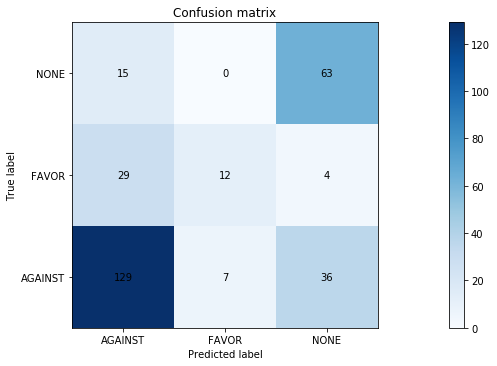

In [122]:
sess = tf.Session()

model_hillary = bert_lstm_model(max_length_in = max_length, 
                                bert_fine_tune_layers = 12, 
                                optimizer = 'adam',
                                learning_rate_in = 0.05,
                                dropout_rate_in = 0.5)

initialize_vars(sess)

model_hillary.fit(
    x = hillary_train_subset['bert'], 
    y = hillary_train_subset['labels_encoded'],
#     validation_split = 0.1,
    shuffle = True,
    epochs = 20,
    verbose = 2,
    batch_size = 32,
    class_weight = hillary_train_subset['class_weights'])

pred_test_hillary = model_hillary.predict(x = hillary_test_subset['bert'])

standard_metrics(true_labels = hillary_test_subset['labels_text'], 
                 test_probs = pred_test_hillary,
                 label_titles = label_categories)

## Run on other Targets
### Abortion

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 95)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
bert_layer_9 (BertLayer)        (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]          

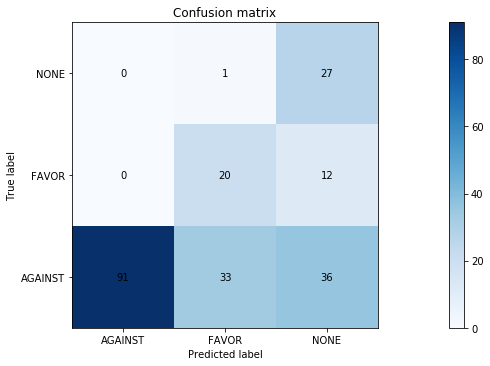

In [79]:
sess = tf.Session()

model_abortion = bert_lstm_model(max_length_in = max_length, 
                                 bert_fine_tune_layers = 12, 
                                 optimizer = 'adam',
                                 learning_rate_in = 0.1,
                                 dropout_rate_in = 0.8)

initialize_vars(sess)

model_abortion.fit(
    x = abortion_train_subset['bert'], 
    y = abortion_train_subset['labels_encoded'],
    validation_split = 0.2,
    shuffle = True,
    epochs = 15,
    verbose = 2,
    batch_size = 32,
    class_weight = abortion_train_subset['class_weights'])

# NOTES:
    # Validation should not be on test data
    # models and weights should be topic-specific
    
pred_test_abortion = model_abortion.predict(x = abortion_test_subset['bert'])

standard_metrics(true_labels = abortion_test_subset['labels_text'], 
                 test_probs = pred_test_abortion,
                 label_titles = label_categories)

### Atheism

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 95)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
bert_layer_11 (BertLayer)       (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]         

/home/timspittle/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/timspittle/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 macro score: 0.14582845242743722
              precision    recall  f1-score   support

     AGAINST       0.00      0.00      0.00        11
       FAVOR       0.86      0.05      0.09       123
        NONE       0.21      0.97      0.35        35

    accuracy                           0.24       169
   macro avg       0.36      0.34      0.15       169
weighted avg       0.67      0.24      0.14       169



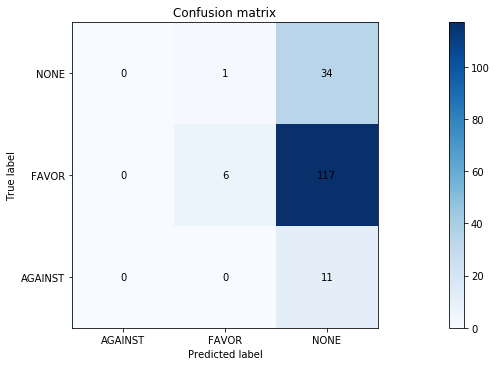

In [71]:
sess = tf.Session()

model_atheism = bert_lstm_model(max_length_in = max_length, 
                                bert_fine_tune_layers = 12, 
                                optimizer = 'adam',
                                learning_rate_in = 0.1,
                                dropout_rate_in = 0.8)

initialize_vars(sess)

model_atheism.fit(
    x = atheism_train_subset['bert'], 
    y = atheism_train_subset['labels_encoded'],
    validation_split = 0.2,
    shuffle = True,
    epochs = 15,
    verbose = 2,
    batch_size = 32,
    class_weight = atheism_train_subset['class_weights'])

pred_test_atheism = model_atheism.predict(x = atheism_test_subset['bert'])

standard_metrics(true_labels = atheism_test_subset['labels_text'], 
                 test_probs = pred_test_atheism,
                 label_titles = label_categories)

### Climate Change

In [72]:
sess = tf.Session()

model_climate = bert_lstm_model(max_length_in = max_length, 
                                bert_fine_tune_layers = 12, 
                                optimizer = 'adam',
                                learning_rate_in = 0.1,
                                dropout_rate_in = 0.8)

initialize_vars(sess)

model_climate.fit(
    x = climate_change_train_subset['bert'], 
    y = climate_change_train_subset['labels_encoded'],
    validation_split = 0.2,
    shuffle = True,
    epochs = 15,
    verbose = 2,
    batch_size = 32,
    class_weight = climate_change_train_subset['class_weights'])

pred_test_climate_change = model_climate.predict(x = climate_change_test_subset['bert'])

standard_metrics(true_labels = climate_change_test_subset['labels_text'], 
                 test_probs = pred_test_climate_change,
                 label_titles = label_categories)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 95)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 95)]         0                                            
__________________________________________________________________________________________________
bert_layer_12 (BertLayer)       (None, None, 768)    108931396   input_ids[0][0]                  
                                                                 input_masks[0][0]         

KeyboardInterrupt: 

### Feminism

In [ ]:
sess = tf.Session()

model_feminism = bert_lstm_model(max_length_in = max_length, 
                                 bert_fine_tune_layers = 12, 
                                 optimizer = 'adam',
                                 learning_rate_in = 0.1,
                                 dropout_rate_in = 0.8)

initialize_vars(sess)

model_feminism.fit(
    x = feminism_train_subset['bert'], 
    y = feminism_train_subset['labels_encoded'],
    validation_split = 0.2,
    shuffle = True,
    epochs = 15,
    verbose = 2,
    batch_size = 32,
    class_weight = feminism_train_subset['class_weights'])

pred_test_feminism = model_feminism.predict(x = feminism_test_subset['bert'])

standard_metrics(true_labels = feminism_test_subset['labels_text'], 
                 test_probs = pred_test_feminism,
                 label_titles = label_categories)

## Extra

In [77]:
# Histograms of predicted probabilities
def class_prob_breakdown(true_labels, test_probs, label_titles):
    plt.figure(figsize=(20, 10))

    plt.subplot(2,3,1)
    plt.title("Prob. Dist. - Predicted " + label_titles[0])
    plt.hist([item[0] for item in test_probs])

    plt.subplot(2,3,2)
    plt.title("Prob. Dist. - Predicted " + label_titles[1])
    plt.hist([item[1] for item in test_probs])

    plt.subplot(2,3,3)
    plt.title("Prob. Dist. - Predicted " + label_titles[2])
    plt.hist([item[2] for item in test_probs])

    plt.subplot(2,3,4)
    plt.title("Prob. Dist., by True Label - " + label_titles[0])
    sns.distplot([item[0] for item in test_probs[true_labels==label_titles[0]]], hist = False, label = "True " + label_titles[0])
    sns.distplot([item[0] for item in test_probs[true_labels==label_titles[1]]], hist = False, label = "True " + label_titles[1])
    sns.distplot([item[0] for item in test_probs[true_labels==label_titles[2]]], hist = False, label = "True " + label_titles[2])

    plt.subplot(2,3,5)
    plt.title("Prob. Dist., by True Label - " + label_titles[1])
    sns.distplot([item[1] for item in test_probs[true_labels==label_titles[0]]], hist = False, label = "True " + label_titles[0])
    sns.distplot([item[1] for item in test_probs[true_labels==label_titles[1]]], hist = False, label = "True " + label_titles[1])
    sns.distplot([item[1] for item in test_probs[true_labels==label_titles[2]]], hist = False, label = "True " + label_titles[2])
    
    plt.subplot(2,3,6)
    plt.title("Prob. Dist., by True Label - " + label_titles[2])
    sns.distplot([item[2] for item in test_probs[true_labels==label_titles[0]]], hist = False, label = "True " + label_titles[0])
    sns.distplot([item[2] for item in test_probs[true_labels==label_titles[1]]], hist = False, label = "True " + label_titles[1])
    sns.distplot([item[2] for item in test_probs[true_labels==label_titles[2]]], hist = False, label = "True " + label_titles[2])

    plt.show()

In [27]:
# model_hillary = KerasClassifier(build_fn = bert_lstm_model(max_length_in = max_length, optimizer = 'adam'),
#                                 validation_split = 0.2, verbose = 2,
#                                 batch_size = 32, epochs = 15)


# # Use GridSearchCV to find the best value for alpha 
# alpha_params = {'bert_fine_tune_layers': [10, 12, 14],
#                'learning_rate_in': [0.1, 0.5, 1],
#                'dropout_rate_in': [0.5, 0.75, 0.9]}
# # alpha_params = {'epochs': [5,10,15],
# #                'batches': [10,32,50]}

# model_hillary_cv = GridSearchCV(estimator = model_hillary, 
#                                 param_grid = alpha_params, 
#                                 return_train_score = True,
#                                 cv = 3, n_jobs = 1)

# model_hillary_cv.fit(
#     X = hillary_train_subset['bert'], 
#     Y = hillary_train_subset['labels_encoded'])

# print('Best Bert Fine Tune Layers parameter: ' + str(model_hillary_cv.best_params_['bert_fine_tune_layers']))
# print('Best Learning Rate parameter: ' + str(model_hillary_cv.best_params_['learning_rate_in']))
# print('Best Dropout Rate parameter: ' + str(model_hillary_cv.best_params_['dropout_rate_in']))

# pred_test_hillary = model_hillary_cv.predict(x = hillary_test_subset['bert'])

# standard_metrics(true_labels = hillary_test_subset['labels_text'], 
#                  test_probs = pred_test_hillary,
#                  label_titles = label_categories)